In [1]:
import torch;
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import pandas as pd
import torchvision.models as models 
from torchvision import transforms, utils
from torch.utils.data.sampler import SubsetRandomSampler
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.autograd import Variable
from torch.optim import lr_scheduler
import seaborn as sns
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
import copy
from tqdm import tqdm
#from model import VAE

import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
from dataloader import *
from model import *

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
#only on validation set
csv_path = 'progress.csv'
img_path = '/home/vip/sayan-mandal/datasets/obj_criteria/good_reduced/'

CDL = CLUnivDataLoader(csv_path, img_path, transform = transforms.Compose([transforms.Resize(64),transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),timestep=5,n=2)

#random sampler
batch_size = 64
validation_split = .2
test_split = .2
train_split = 1-validation_split-test_split
shuffle_dataset = True

# Creating data indices for training and validation splits:
dataset_size = len(CDL)
indices = list(range(dataset_size))
split_train = int(np.floor(train_split * dataset_size))
split_valid = int(np.floor((train_split+validation_split) * dataset_size))
if shuffle_dataset :
    np.random.shuffle(indices)
train_indices, val_indices, test_indices =  indices[:split_train],indices[split_train:split_valid],indices[split_valid:]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

train_loader = torch.utils.data.DataLoader(CDL, batch_size=batch_size, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(CDL, batch_size=batch_size, sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(CDL, batch_size=batch_size, sampler=test_sampler)

<AxesSubplot:xlabel='Slope ($\\mu$m/y)', ylabel='Count'>

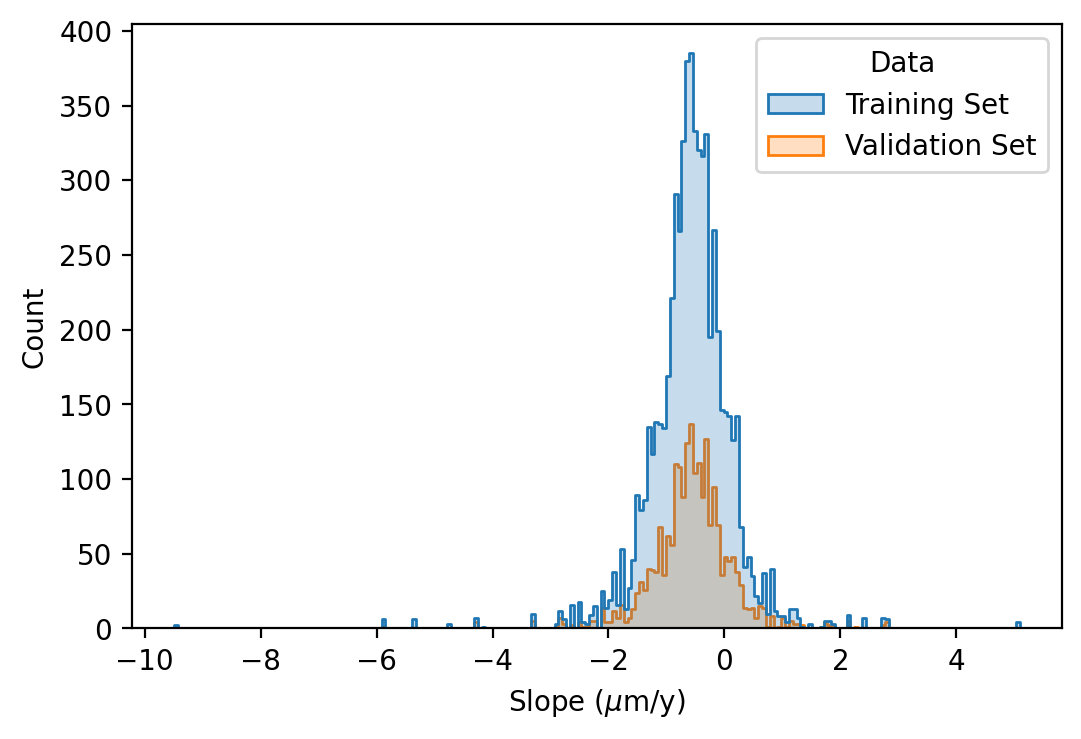

In [4]:

for batch_idx, (_, targets, _) in enumerate(train_loader):
    targets = Variable(targets.view(targets.shape[0],-1))

    if batch_idx == 0:
        true_scores = targets.cpu().numpy()
    else:
        true_scores = np.append(true_scores, targets.cpu().numpy(), axis = 0)

for batch_idx, (_, targets, _) in enumerate(valid_loader):
    targets = Variable(targets.view(targets.shape[0],-1))

    if batch_idx == 0:
        valtrue_scores = targets.cpu().numpy()
    else:
        valtrue_scores = np.append(valtrue_scores, targets.cpu().numpy(), axis = 0)

from scipy.stats import ks_2samp
dfx = pd.DataFrame.from_dict({'Slope ($\mu$m/y)': true_scores.ravel().tolist(), 'Data':'Training Set'})
dfy = pd.DataFrame.from_dict({'Slope ($\mu$m/y)': valtrue_scores.ravel().tolist(), 'Data':'Validation Set'})
df = pd.concat(axis=0, ignore_index=True, objs=[dfx,dfy])



fig,ax = plt.subplots()
sns.histplot(df,x='Slope ($\mu$m/y)',hue='Data',ax=ax, element='step')


In [5]:
print(len(true_scores), len(valtrue_scores))

6421 2141


In [8]:
torch.cuda.empty_cache()
tl = iter(train_loader)
dat,_,_ = next(tl)
bs, ts, C, H, W = dat.shape
n_out = 1

model = CNNLSTMNet(channels = C, ts = ts, n_out = n_out, device = device).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1)  #,momentum=0.9, nesterov=True)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100], gamma= 0.1)
criterion = nn.MSELoss()  # this is for regression mean squared loss

In [9]:
epochs = 150
best_loss =float('inf')
ep, trainloss, validloss, testloss = [],[],[],[]
testep, totloss = [],[]
besttrloss, bestvalloss, besttsloss = 0,0,0
for epoch in range(1,epochs+1):
    model.train()
    loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=True)
    trloss = 0
    for batch_idx, (data, targets, _) in loop:
        optimizer.zero_grad() 
        data = Variable(data).to(device)
        targets = Variable(targets.to(torch.float).view(targets.shape[0],-1)).to(device)

        #forward pass
        scores = model(data)
        loss = criterion(scores, targets)
        trloss += loss.item()
        #backward pass   
        loss.backward()

        #gradient descent
        optimizer.step()
        loop.set_description(f"Epoch [{epoch}/{epochs}]")
        loop.set_postfix(batch_loss = loss.item(), running_loss = trloss )
    scheduler.step()

    model.eval()
    valloss = 0
    with torch.no_grad():
        for data, targets, _ in valid_loader:
            data = Variable(data).to(device)
            targets = Variable(targets.to(torch.float).view(targets.shape[0],-1)).to(device)

            
            scores = model(data)
            loss = criterion(scores, targets)

            valloss += loss.item()

    if valloss < best_loss:
        tsloss = 0
        with torch.no_grad():
            for data, targets, _ in test_loader:
                data = Variable(data).to(device)
                targets = Variable(targets.to(torch.float).view(targets.shape[0],-1)).to(device)

                
                scores = model(data)
                loss = criterion(scores, targets)

                tsloss += loss.item()
            testloss += [tsloss]
            testep += [epoch]
        to_print = "Train Loss: {:.4f} | Valid Loss: {:.4f} ===========> {:.4f} | Test Loss: {:.4f} | Saving model...".format(trloss, best_loss, valloss, tsloss)
        best_loss = valloss
        bestvalloss = valloss
        besttrloss = trloss
        besttsloss = tsloss
        best_e = epoch
        best_model = copy.deepcopy(model)
    else:
        to_print = "Train Loss: {:.4f} | Valid Loss: {:.4f}".format(trloss, valloss)

    print(to_print)
    ep+=[epoch]
    trainloss += [trloss]
    validloss += [valloss]
    totloss += [trloss + valloss]

Epoch [1/150]: 100%|██████████| 101/101 [00:19<00:00,  5.22it/s, batch_loss=0.414, running_loss=54.9]


Train Loss: 54.9035 | Valid Loss: inf ===========> 16.3105 | Test Loss: 19.4068 | Saving model...


Epoch [2/150]: 100%|██████████| 101/101 [00:19<00:00,  5.17it/s, batch_loss=0.257, running_loss=54.2]


Train Loss: 54.1862 | Valid Loss: 16.3105 ===========> 16.2099 | Test Loss: 19.5040 | Saving model...


Epoch [3/150]: 100%|██████████| 101/101 [00:19<00:00,  5.22it/s, batch_loss=0.176, running_loss=53.9]


Train Loss: 53.8946 | Valid Loss: 16.2099 ===========> 16.1971 | Test Loss: 19.3539 | Saving model...


Epoch [4/150]: 100%|██████████| 101/101 [00:19<00:00,  5.26it/s, batch_loss=0.339, running_loss=53.9]


Train Loss: 53.8655 | Valid Loss: 16.2302


Epoch [5/150]: 100%|██████████| 101/101 [00:19<00:00,  5.27it/s, batch_loss=0.445, running_loss=53.8]


Train Loss: 53.8090 | Valid Loss: 16.4234


Epoch [6/150]: 100%|██████████| 101/101 [00:19<00:00,  5.26it/s, batch_loss=0.218, running_loss=52.8]


Train Loss: 52.7500 | Valid Loss: 16.1971 ===========> 16.1942 | Test Loss: 19.3829 | Saving model...


Epoch [7/150]: 100%|██████████| 101/101 [00:19<00:00,  5.28it/s, batch_loss=0.286, running_loss=52]


Train Loss: 52.0356 | Valid Loss: 16.3062


Epoch [8/150]: 100%|██████████| 101/101 [00:19<00:00,  5.27it/s, batch_loss=0.422, running_loss=51.5]


Train Loss: 51.5305 | Valid Loss: 16.1942 ===========> 15.4765 | Test Loss: 18.5712 | Saving model...


Epoch [9/150]: 100%|██████████| 101/101 [00:19<00:00,  5.26it/s, batch_loss=0.446, running_loss=50.1]


Train Loss: 50.0593 | Valid Loss: 15.7646


Epoch [10/150]: 100%|██████████| 101/101 [00:19<00:00,  5.25it/s, batch_loss=0.21, running_loss=49]


Train Loss: 48.9761 | Valid Loss: 15.4765 ===========> 15.1576 | Test Loss: 18.3837 | Saving model...


Epoch [11/150]: 100%|██████████| 101/101 [00:19<00:00,  5.27it/s, batch_loss=0.143, running_loss=47.9]


Train Loss: 47.9397 | Valid Loss: 15.2840


Epoch [12/150]: 100%|██████████| 101/101 [00:19<00:00,  5.26it/s, batch_loss=0.39, running_loss=50.2]


Train Loss: 50.1654 | Valid Loss: 15.1576 ===========> 15.0964 | Test Loss: 18.0917 | Saving model...


Epoch [13/150]: 100%|██████████| 101/101 [00:19<00:00,  5.11it/s, batch_loss=2.85, running_loss=48.9]


Train Loss: 48.8919 | Valid Loss: 683.3022


Epoch [14/150]: 100%|██████████| 101/101 [00:19<00:00,  5.08it/s, batch_loss=0.305, running_loss=69.5]


Train Loss: 69.4721 | Valid Loss: 16.5033


Epoch [15/150]: 100%|██████████| 101/101 [00:19<00:00,  5.12it/s, batch_loss=0.122, running_loss=54]


Train Loss: 54.0487 | Valid Loss: 16.6183


Epoch [16/150]: 100%|██████████| 101/101 [00:19<00:00,  5.10it/s, batch_loss=0.357, running_loss=54.3]


Train Loss: 54.2574 | Valid Loss: 16.2622


Epoch [17/150]: 100%|██████████| 101/101 [00:19<00:00,  5.13it/s, batch_loss=0.512, running_loss=54.3]


Train Loss: 54.3130 | Valid Loss: 16.2766


Epoch [18/150]: 100%|██████████| 101/101 [00:19<00:00,  5.13it/s, batch_loss=0.374, running_loss=54.2]


Train Loss: 54.2468 | Valid Loss: 16.2306


Epoch [19/150]: 100%|██████████| 101/101 [00:19<00:00,  5.11it/s, batch_loss=0.506, running_loss=54.4]


Train Loss: 54.3582 | Valid Loss: 16.2005


Epoch [20/150]: 100%|██████████| 101/101 [00:19<00:00,  5.11it/s, batch_loss=0.486, running_loss=54.3]


Train Loss: 54.3061 | Valid Loss: 16.2362


Epoch [21/150]: 100%|██████████| 101/101 [00:19<00:00,  5.13it/s, batch_loss=0.276, running_loss=54.1]


Train Loss: 54.1446 | Valid Loss: 16.3495


Epoch [22/150]: 100%|██████████| 101/101 [00:19<00:00,  5.13it/s, batch_loss=0.362, running_loss=54.2]


Train Loss: 54.2370 | Valid Loss: 16.3922


Epoch [23/150]: 100%|██████████| 101/101 [00:19<00:00,  5.11it/s, batch_loss=0.351, running_loss=54.2]


Train Loss: 54.1783 | Valid Loss: 16.2580


Epoch [24/150]: 100%|██████████| 101/101 [00:19<00:00,  5.11it/s, batch_loss=0.174, running_loss=54]


Train Loss: 54.0022 | Valid Loss: 16.3354


Epoch [25/150]: 100%|██████████| 101/101 [00:19<00:00,  5.12it/s, batch_loss=0.257, running_loss=54.1]


Train Loss: 54.0862 | Valid Loss: 16.3369


Epoch [26/150]: 100%|██████████| 101/101 [00:19<00:00,  5.12it/s, batch_loss=0.365, running_loss=54.1]


Train Loss: 54.1187 | Valid Loss: 16.3981


Epoch [27/150]: 100%|██████████| 101/101 [00:19<00:00,  5.13it/s, batch_loss=0.591, running_loss=54.3]


Train Loss: 54.2831 | Valid Loss: 16.3793


Epoch [28/150]: 100%|██████████| 101/101 [00:19<00:00,  5.13it/s, batch_loss=0.832, running_loss=54.3]


Train Loss: 54.2646 | Valid Loss: 16.9086


Epoch [29/150]: 100%|██████████| 101/101 [00:19<00:00,  5.14it/s, batch_loss=0.158, running_loss=53.6]


Train Loss: 53.5920 | Valid Loss: 16.1721


Epoch [30/150]: 100%|██████████| 101/101 [00:19<00:00,  5.14it/s, batch_loss=0.447, running_loss=53.6]


Train Loss: 53.6161 | Valid Loss: 16.4289


Epoch [31/150]: 100%|██████████| 101/101 [00:19<00:00,  5.13it/s, batch_loss=0.357, running_loss=52.9]


Train Loss: 52.9319 | Valid Loss: 16.0623


Epoch [32/150]: 100%|██████████| 101/101 [00:19<00:00,  5.14it/s, batch_loss=0.36, running_loss=52.5]


Train Loss: 52.4673 | Valid Loss: 16.9484


Epoch [33/150]: 100%|██████████| 101/101 [00:19<00:00,  5.13it/s, batch_loss=0.228, running_loss=51.2]


Train Loss: 51.2322 | Valid Loss: 16.3897


Epoch [34/150]: 100%|██████████| 101/101 [00:19<00:00,  5.11it/s, batch_loss=0.386, running_loss=50.4]


Train Loss: 50.4249 | Valid Loss: 18.6692


Epoch [35/150]: 100%|██████████| 101/101 [00:19<00:00,  5.13it/s, batch_loss=0.256, running_loss=49.3]


Train Loss: 49.3118 | Valid Loss: 16.6838


Epoch [36/150]: 100%|██████████| 101/101 [00:19<00:00,  5.13it/s, batch_loss=0.34, running_loss=48.6]


Train Loss: 48.6434 | Valid Loss: 15.9856


Epoch [37/150]: 100%|██████████| 101/101 [00:19<00:00,  5.12it/s, batch_loss=0.266, running_loss=48.8]


Train Loss: 48.8458 | Valid Loss: 15.9914


Epoch [38/150]: 100%|██████████| 101/101 [00:19<00:00,  5.12it/s, batch_loss=0.444, running_loss=45.3]


Train Loss: 45.3200 | Valid Loss: 17.5475


Epoch [39/150]: 100%|██████████| 101/101 [00:19<00:00,  5.15it/s, batch_loss=0.68, running_loss=45.9]


Train Loss: 45.9378 | Valid Loss: 17.8706


Epoch [40/150]: 100%|██████████| 101/101 [00:19<00:00,  5.13it/s, batch_loss=0.589, running_loss=44.9]


Train Loss: 44.8538 | Valid Loss: 16.7597


Epoch [41/150]: 100%|██████████| 101/101 [00:19<00:00,  5.13it/s, batch_loss=0.679, running_loss=42.7]


Train Loss: 42.6620 | Valid Loss: 24.5690


Epoch [42/150]: 100%|██████████| 101/101 [00:19<00:00,  5.13it/s, batch_loss=0.257, running_loss=44.4]


Train Loss: 44.3940 | Valid Loss: 15.2814


Epoch [43/150]: 100%|██████████| 101/101 [00:19<00:00,  5.12it/s, batch_loss=0.197, running_loss=40.4]


Train Loss: 40.3985 | Valid Loss: 15.1734


Epoch [44/150]: 100%|██████████| 101/101 [00:19<00:00,  5.14it/s, batch_loss=0.798, running_loss=42.5]


Train Loss: 42.4658 | Valid Loss: 16.1567


Epoch [45/150]: 100%|██████████| 101/101 [00:19<00:00,  5.13it/s, batch_loss=1.73, running_loss=40.6]


Train Loss: 40.6128 | Valid Loss: 16.2976


Epoch [46/150]: 100%|██████████| 101/101 [00:19<00:00,  5.12it/s, batch_loss=0.177, running_loss=49.5]


Train Loss: 49.4545 | Valid Loss: 15.0964 ===========> 15.0602 | Test Loss: 17.5692 | Saving model...


Epoch [47/150]: 100%|██████████| 101/101 [00:19<00:00,  5.15it/s, batch_loss=0.317, running_loss=40.8]


Train Loss: 40.8403 | Valid Loss: 15.7754


Epoch [48/150]: 100%|██████████| 101/101 [00:19<00:00,  5.15it/s, batch_loss=0.473, running_loss=35.2]


Train Loss: 35.1760 | Valid Loss: 15.0602 ===========> 14.7747 | Test Loss: 16.8924 | Saving model...


Epoch [49/150]: 100%|██████████| 101/101 [00:19<00:00,  5.13it/s, batch_loss=0.135, running_loss=34.7]


Train Loss: 34.7167 | Valid Loss: 16.0476


Epoch [50/150]: 100%|██████████| 101/101 [00:19<00:00,  5.19it/s, batch_loss=0.283, running_loss=32.8]


Train Loss: 32.7678 | Valid Loss: 14.7747 ===========> 14.4992 | Test Loss: 17.2711 | Saving model...


Epoch [51/150]: 100%|██████████| 101/101 [00:19<00:00,  5.17it/s, batch_loss=0.228, running_loss=30]


Train Loss: 29.9551 | Valid Loss: 16.2882


Epoch [52/150]: 100%|██████████| 101/101 [00:19<00:00,  5.18it/s, batch_loss=0.177, running_loss=29.4]


Train Loss: 29.3505 | Valid Loss: 15.3743


Epoch [53/150]: 100%|██████████| 101/101 [00:19<00:00,  5.18it/s, batch_loss=0.285, running_loss=26.5]


Train Loss: 26.5014 | Valid Loss: 17.7201


Epoch [54/150]: 100%|██████████| 101/101 [00:19<00:00,  5.18it/s, batch_loss=0.237, running_loss=24.3]


Train Loss: 24.2829 | Valid Loss: 14.4992 ===========> 13.4413 | Test Loss: 16.0071 | Saving model...


Epoch [55/150]: 100%|██████████| 101/101 [00:19<00:00,  5.19it/s, batch_loss=0.191, running_loss=23.6]


Train Loss: 23.6279 | Valid Loss: 13.4413 ===========> 13.2208 | Test Loss: 16.2821 | Saving model...


Epoch [56/150]: 100%|██████████| 101/101 [00:19<00:00,  5.18it/s, batch_loss=0.0668, running_loss=21.2]


Train Loss: 21.1629 | Valid Loss: 13.2208 ===========> 13.1326 | Test Loss: 15.6749 | Saving model...


Epoch [57/150]: 100%|██████████| 101/101 [00:19<00:00,  5.18it/s, batch_loss=0.214, running_loss=20.4]


Train Loss: 20.4138 | Valid Loss: 13.6419


Epoch [58/150]: 100%|██████████| 101/101 [00:19<00:00,  5.18it/s, batch_loss=0.249, running_loss=18.6]


Train Loss: 18.6203 | Valid Loss: 13.1326 ===========> 12.5087 | Test Loss: 16.0778 | Saving model...


Epoch [59/150]: 100%|██████████| 101/101 [00:19<00:00,  5.18it/s, batch_loss=0.137, running_loss=17.4]


Train Loss: 17.3696 | Valid Loss: 15.9762


Epoch [60/150]: 100%|██████████| 101/101 [00:19<00:00,  5.18it/s, batch_loss=0.0993, running_loss=15]


Train Loss: 14.9996 | Valid Loss: 15.1671


Epoch [61/150]: 100%|██████████| 101/101 [00:19<00:00,  5.19it/s, batch_loss=0.163, running_loss=14.1]


Train Loss: 14.1111 | Valid Loss: 15.5630


Epoch [62/150]: 100%|██████████| 101/101 [00:19<00:00,  5.18it/s, batch_loss=0.117, running_loss=13.6]


Train Loss: 13.5761 | Valid Loss: 12.5087 ===========> 12.0401 | Test Loss: 14.2338 | Saving model...


Epoch [63/150]: 100%|██████████| 101/101 [00:19<00:00,  5.18it/s, batch_loss=0.137, running_loss=12]


Train Loss: 11.9813 | Valid Loss: 13.7497


Epoch [64/150]: 100%|██████████| 101/101 [00:19<00:00,  5.16it/s, batch_loss=0.113, running_loss=10.9]


Train Loss: 10.8841 | Valid Loss: 12.2683


Epoch [65/150]: 100%|██████████| 101/101 [00:19<00:00,  5.18it/s, batch_loss=0.0678, running_loss=10.5]


Train Loss: 10.4883 | Valid Loss: 12.0401 ===========> 11.8927 | Test Loss: 14.4089 | Saving model...


Epoch [66/150]: 100%|██████████| 101/101 [00:19<00:00,  5.19it/s, batch_loss=0.0703, running_loss=9.48]


Train Loss: 9.4846 | Valid Loss: 12.1462


Epoch [67/150]: 100%|██████████| 101/101 [00:19<00:00,  5.19it/s, batch_loss=0.073, running_loss=8.55]


Train Loss: 8.5469 | Valid Loss: 12.4755


Epoch [68/150]: 100%|██████████| 101/101 [00:19<00:00,  5.18it/s, batch_loss=0.0737, running_loss=7.23]


Train Loss: 7.2341 | Valid Loss: 12.5246


Epoch [69/150]: 100%|██████████| 101/101 [00:19<00:00,  5.17it/s, batch_loss=0.0281, running_loss=7.24]


Train Loss: 7.2409 | Valid Loss: 11.8927 ===========> 11.7890 | Test Loss: 14.0683 | Saving model...


Epoch [70/150]: 100%|██████████| 101/101 [00:19<00:00,  5.18it/s, batch_loss=0.0504, running_loss=6.51]


Train Loss: 6.5111 | Valid Loss: 11.7890 ===========> 11.0663 | Test Loss: 13.4224 | Saving model...


Epoch [71/150]: 100%|██████████| 101/101 [00:19<00:00,  5.18it/s, batch_loss=0.0784, running_loss=5.47]


Train Loss: 5.4719 | Valid Loss: 12.7268


Epoch [72/150]: 100%|██████████| 101/101 [00:19<00:00,  5.19it/s, batch_loss=0.0326, running_loss=5.64]


Train Loss: 5.6372 | Valid Loss: 11.0663 ===========> 10.7817 | Test Loss: 13.4397 | Saving model...


Epoch [73/150]: 100%|██████████| 101/101 [00:19<00:00,  5.17it/s, batch_loss=0.0495, running_loss=5.53]


Train Loss: 5.5314 | Valid Loss: 12.3454


Epoch [74/150]: 100%|██████████| 101/101 [00:19<00:00,  5.17it/s, batch_loss=0.0789, running_loss=4.91]


Train Loss: 4.9113 | Valid Loss: 11.5660


Epoch [75/150]: 100%|██████████| 101/101 [00:19<00:00,  5.16it/s, batch_loss=0.0582, running_loss=4.7]


Train Loss: 4.7035 | Valid Loss: 11.1326


Epoch [76/150]: 100%|██████████| 101/101 [00:19<00:00,  5.17it/s, batch_loss=0.065, running_loss=4.21]


Train Loss: 4.2127 | Valid Loss: 10.7817 ===========> 10.4449 | Test Loss: 12.6762 | Saving model...


Epoch [77/150]: 100%|██████████| 101/101 [00:19<00:00,  5.17it/s, batch_loss=0.0634, running_loss=3.69]


Train Loss: 3.6948 | Valid Loss: 13.0579


Epoch [78/150]: 100%|██████████| 101/101 [00:19<00:00,  5.19it/s, batch_loss=0.0227, running_loss=3.69]


Train Loss: 3.6945 | Valid Loss: 10.4449 ===========> 10.1207 | Test Loss: 12.6874 | Saving model...


Epoch [79/150]: 100%|██████████| 101/101 [00:19<00:00,  5.18it/s, batch_loss=0.0316, running_loss=3.39]


Train Loss: 3.3919 | Valid Loss: 10.5967


Epoch [80/150]: 100%|██████████| 101/101 [00:19<00:00,  5.16it/s, batch_loss=0.0198, running_loss=3.17]


Train Loss: 3.1721 | Valid Loss: 10.1207 ===========> 10.0471 | Test Loss: 12.3695 | Saving model...


Epoch [81/150]: 100%|██████████| 101/101 [00:19<00:00,  5.19it/s, batch_loss=0.0367, running_loss=3.05]


Train Loss: 3.0519 | Valid Loss: 10.4117


Epoch [82/150]: 100%|██████████| 101/101 [00:19<00:00,  5.19it/s, batch_loss=0.0263, running_loss=3.02]


Train Loss: 3.0243 | Valid Loss: 10.2776


Epoch [83/150]: 100%|██████████| 101/101 [00:19<00:00,  5.18it/s, batch_loss=0.0571, running_loss=2.83]


Train Loss: 2.8301 | Valid Loss: 10.0471 ===========> 9.9957 | Test Loss: 12.3289 | Saving model...


Epoch [84/150]: 100%|██████████| 101/101 [00:19<00:00,  5.18it/s, batch_loss=0.0297, running_loss=2.9]


Train Loss: 2.8952 | Valid Loss: 9.9957 ===========> 9.6042 | Test Loss: 12.3678 | Saving model...


Epoch [85/150]: 100%|██████████| 101/101 [00:19<00:00,  5.18it/s, batch_loss=0.0331, running_loss=2.63]


Train Loss: 2.6257 | Valid Loss: 10.2833


Epoch [86/150]: 100%|██████████| 101/101 [00:19<00:00,  5.18it/s, batch_loss=0.019, running_loss=2.45]


Train Loss: 2.4542 | Valid Loss: 9.8927


Epoch [87/150]: 100%|██████████| 101/101 [00:19<00:00,  5.19it/s, batch_loss=0.0329, running_loss=2.37]


Train Loss: 2.3726 | Valid Loss: 9.6042 ===========> 9.5908 | Test Loss: 12.0218 | Saving model...


Epoch [88/150]: 100%|██████████| 101/101 [00:19<00:00,  5.20it/s, batch_loss=0.0171, running_loss=2.42]


Train Loss: 2.4199 | Valid Loss: 10.0248


Epoch [89/150]: 100%|██████████| 101/101 [00:19<00:00,  5.19it/s, batch_loss=0.0154, running_loss=2.27]


Train Loss: 2.2709 | Valid Loss: 9.7696


Epoch [90/150]: 100%|██████████| 101/101 [00:19<00:00,  5.21it/s, batch_loss=0.015, running_loss=2.25]


Train Loss: 2.2459 | Valid Loss: 9.5908 ===========> 9.5523 | Test Loss: 12.1937 | Saving model...


Epoch [91/150]: 100%|██████████| 101/101 [00:19<00:00,  5.09it/s, batch_loss=0.0229, running_loss=2.1]


Train Loss: 2.0997 | Valid Loss: 9.5938


Epoch [92/150]: 100%|██████████| 101/101 [00:19<00:00,  5.12it/s, batch_loss=0.0133, running_loss=2.05]


Train Loss: 2.0497 | Valid Loss: 10.1759


Epoch [93/150]: 100%|██████████| 101/101 [00:19<00:00,  5.13it/s, batch_loss=0.0136, running_loss=1.98]


Train Loss: 1.9813 | Valid Loss: 9.8097


Epoch [94/150]: 100%|██████████| 101/101 [00:19<00:00,  5.10it/s, batch_loss=0.0353, running_loss=1.92]


Train Loss: 1.9172 | Valid Loss: 9.5523 ===========> 9.4700 | Test Loss: 11.8946 | Saving model...


Epoch [95/150]: 100%|██████████| 101/101 [00:19<00:00,  5.10it/s, batch_loss=0.0173, running_loss=1.83]


Train Loss: 1.8310 | Valid Loss: 9.7294


Epoch [96/150]: 100%|██████████| 101/101 [00:19<00:00,  5.11it/s, batch_loss=0.029, running_loss=1.91]


Train Loss: 1.9060 | Valid Loss: 10.2153


Epoch [97/150]: 100%|██████████| 101/101 [00:19<00:00,  5.10it/s, batch_loss=0.0447, running_loss=1.93]


Train Loss: 1.9305 | Valid Loss: 11.1452


Epoch [98/150]: 100%|██████████| 101/101 [00:19<00:00,  5.10it/s, batch_loss=0.0214, running_loss=1.77]


Train Loss: 1.7714 | Valid Loss: 9.6662


Epoch [99/150]: 100%|██████████| 101/101 [00:19<00:00,  5.12it/s, batch_loss=0.0342, running_loss=1.78]


Train Loss: 1.7771 | Valid Loss: 9.4700 ===========> 9.3629 | Test Loss: 11.8948 | Saving model...


Epoch [100/150]: 100%|██████████| 101/101 [00:19<00:00,  5.11it/s, batch_loss=0.0167, running_loss=1.72]


Train Loss: 1.7169 | Valid Loss: 9.3629 ===========> 9.3158 | Test Loss: 11.9330 | Saving model...


Epoch [101/150]: 100%|██████████| 101/101 [00:19<00:00,  5.13it/s, batch_loss=0.00991, running_loss=1.52]


Train Loss: 1.5178 | Valid Loss: 9.3158 ===========> 9.2791 | Test Loss: 11.7639 | Saving model...


Epoch [102/150]: 100%|██████████| 101/101 [00:19<00:00,  5.11it/s, batch_loss=0.00506, running_loss=1.47]


Train Loss: 1.4749 | Valid Loss: 9.2791 ===========> 9.2393 | Test Loss: 11.8042 | Saving model...


Epoch [103/150]: 100%|██████████| 101/101 [00:19<00:00,  5.10it/s, batch_loss=0.0109, running_loss=1.45]


Train Loss: 1.4471 | Valid Loss: 9.2450


Epoch [104/150]: 100%|██████████| 101/101 [00:19<00:00,  5.11it/s, batch_loss=0.0176, running_loss=1.39]


Train Loss: 1.3945 | Valid Loss: 9.3352


Epoch [105/150]: 100%|██████████| 101/101 [00:19<00:00,  5.12it/s, batch_loss=0.0079, running_loss=1.34]


Train Loss: 1.3356 | Valid Loss: 9.2393 ===========> 9.2052 | Test Loss: 11.6778 | Saving model...


Epoch [106/150]: 100%|██████████| 101/101 [00:19<00:00,  5.12it/s, batch_loss=0.0217, running_loss=1.38]


Train Loss: 1.3769 | Valid Loss: 9.3616


Epoch [107/150]: 100%|██████████| 101/101 [00:19<00:00,  5.13it/s, batch_loss=0.0152, running_loss=1.33]


Train Loss: 1.3261 | Valid Loss: 9.2092


Epoch [108/150]: 100%|██████████| 101/101 [00:19<00:00,  5.12it/s, batch_loss=0.0177, running_loss=1.33]


Train Loss: 1.3280 | Valid Loss: 9.2959


Epoch [109/150]: 100%|██████████| 101/101 [00:19<00:00,  5.11it/s, batch_loss=0.012, running_loss=1.31]


Train Loss: 1.3122 | Valid Loss: 9.2242


Epoch [110/150]: 100%|██████████| 101/101 [00:19<00:00,  5.13it/s, batch_loss=0.0118, running_loss=1.33]


Train Loss: 1.3318 | Valid Loss: 9.4041


Epoch [111/150]: 100%|██████████| 101/101 [00:19<00:00,  5.14it/s, batch_loss=0.0144, running_loss=1.29]


Train Loss: 1.2922 | Valid Loss: 9.2530


Epoch [112/150]: 100%|██████████| 101/101 [00:19<00:00,  5.11it/s, batch_loss=0.0232, running_loss=1.28]


Train Loss: 1.2783 | Valid Loss: 9.2538


Epoch [113/150]: 100%|██████████| 101/101 [00:19<00:00,  5.12it/s, batch_loss=0.0179, running_loss=1.31]


Train Loss: 1.3096 | Valid Loss: 9.2327


Epoch [114/150]: 100%|██████████| 101/101 [00:19<00:00,  5.11it/s, batch_loss=0.0119, running_loss=1.27]


Train Loss: 1.2683 | Valid Loss: 9.4500


Epoch [115/150]: 100%|██████████| 101/101 [00:19<00:00,  5.12it/s, batch_loss=0.0109, running_loss=1.21]


Train Loss: 1.2070 | Valid Loss: 9.3359


Epoch [116/150]: 100%|██████████| 101/101 [00:19<00:00,  5.10it/s, batch_loss=0.0213, running_loss=1.31]


Train Loss: 1.3115 | Valid Loss: 9.2052 ===========> 9.1989 | Test Loss: 11.7094 | Saving model...


Epoch [117/150]: 100%|██████████| 101/101 [00:19<00:00,  5.10it/s, batch_loss=0.0119, running_loss=1.27]


Train Loss: 1.2651 | Valid Loss: 9.1989 ===========> 9.1509 | Test Loss: 11.5983 | Saving model...


Epoch [118/150]: 100%|██████████| 101/101 [00:19<00:00,  5.10it/s, batch_loss=0.0139, running_loss=1.3]


Train Loss: 1.2963 | Valid Loss: 9.1847


Epoch [119/150]: 100%|██████████| 101/101 [00:19<00:00,  5.13it/s, batch_loss=0.0164, running_loss=1.23]


Train Loss: 1.2283 | Valid Loss: 9.2676


Epoch [120/150]: 100%|██████████| 101/101 [00:19<00:00,  5.11it/s, batch_loss=0.0151, running_loss=1.27]


Train Loss: 1.2691 | Valid Loss: 9.1509 ===========> 9.1506 | Test Loss: 11.5661 | Saving model...


Epoch [121/150]: 100%|██████████| 101/101 [00:19<00:00,  5.10it/s, batch_loss=0.00851, running_loss=1.25]


Train Loss: 1.2530 | Valid Loss: 9.4186


Epoch [122/150]: 100%|██████████| 101/101 [00:19<00:00,  5.13it/s, batch_loss=0.0225, running_loss=1.2]


Train Loss: 1.1978 | Valid Loss: 9.4639


Epoch [123/150]: 100%|██████████| 101/101 [00:19<00:00,  5.11it/s, batch_loss=0.00541, running_loss=1.22]


Train Loss: 1.2225 | Valid Loss: 9.3875


Epoch [124/150]: 100%|██████████| 101/101 [00:19<00:00,  5.13it/s, batch_loss=0.0179, running_loss=1.21]


Train Loss: 1.2057 | Valid Loss: 9.1507


Epoch [125/150]: 100%|██████████| 101/101 [00:19<00:00,  5.11it/s, batch_loss=0.00919, running_loss=1.27]


Train Loss: 1.2733 | Valid Loss: 9.2469


Epoch [126/150]: 100%|██████████| 101/101 [00:19<00:00,  5.12it/s, batch_loss=0.0136, running_loss=1.23]


Train Loss: 1.2259 | Valid Loss: 9.2518


Epoch [127/150]: 100%|██████████| 101/101 [00:19<00:00,  5.10it/s, batch_loss=0.015, running_loss=1.21]


Train Loss: 1.2129 | Valid Loss: 9.2769


Epoch [128/150]: 100%|██████████| 101/101 [00:19<00:00,  5.11it/s, batch_loss=0.00501, running_loss=1.22]


Train Loss: 1.2248 | Valid Loss: 9.1535


Epoch [129/150]: 100%|██████████| 101/101 [00:19<00:00,  5.11it/s, batch_loss=0.00647, running_loss=1.22]


Train Loss: 1.2229 | Valid Loss: 9.5326


Epoch [130/150]: 100%|██████████| 101/101 [00:19<00:00,  5.11it/s, batch_loss=0.00674, running_loss=1.21]


Train Loss: 1.2092 | Valid Loss: 9.2209


Epoch [131/150]: 100%|██████████| 101/101 [00:19<00:00,  5.12it/s, batch_loss=0.00667, running_loss=1.21]


Train Loss: 1.2066 | Valid Loss: 9.1963


Epoch [132/150]: 100%|██████████| 101/101 [00:19<00:00,  5.11it/s, batch_loss=0.00879, running_loss=1.13]


Train Loss: 1.1292 | Valid Loss: 9.2684


Epoch [133/150]: 100%|██████████| 101/101 [00:19<00:00,  5.13it/s, batch_loss=0.0232, running_loss=1.16]


Train Loss: 1.1639 | Valid Loss: 9.2069


Epoch [134/150]: 100%|██████████| 101/101 [00:19<00:00,  5.10it/s, batch_loss=0.0152, running_loss=1.14]


Train Loss: 1.1375 | Valid Loss: 9.2263


Epoch [135/150]: 100%|██████████| 101/101 [00:19<00:00,  5.11it/s, batch_loss=0.0153, running_loss=1.25]


Train Loss: 1.2477 | Valid Loss: 9.1506 ===========> 9.1102 | Test Loss: 11.5265 | Saving model...


Epoch [136/150]: 100%|██████████| 101/101 [00:19<00:00,  5.11it/s, batch_loss=0.0319, running_loss=1.21]


Train Loss: 1.2119 | Valid Loss: 9.1585


Epoch [137/150]: 100%|██████████| 101/101 [00:19<00:00,  5.11it/s, batch_loss=0.00861, running_loss=1.13]


Train Loss: 1.1309 | Valid Loss: 9.4270


Epoch [138/150]: 100%|██████████| 101/101 [00:19<00:00,  5.13it/s, batch_loss=0.0113, running_loss=1.16]


Train Loss: 1.1639 | Valid Loss: 9.2501


Epoch [139/150]: 100%|██████████| 101/101 [00:19<00:00,  5.12it/s, batch_loss=0.0132, running_loss=1.15]


Train Loss: 1.1521 | Valid Loss: 9.1415


Epoch [140/150]: 100%|██████████| 101/101 [00:19<00:00,  5.11it/s, batch_loss=0.014, running_loss=1.18]


Train Loss: 1.1770 | Valid Loss: 9.2004


Epoch [141/150]: 100%|██████████| 101/101 [00:19<00:00,  5.12it/s, batch_loss=0.019, running_loss=1.19]


Train Loss: 1.1942 | Valid Loss: 9.3762


Epoch [142/150]: 100%|██████████| 101/101 [00:19<00:00,  5.14it/s, batch_loss=0.00522, running_loss=1.13]


Train Loss: 1.1331 | Valid Loss: 9.2682


Epoch [143/150]: 100%|██████████| 101/101 [00:19<00:00,  5.09it/s, batch_loss=0.00889, running_loss=1.16]


Train Loss: 1.1610 | Valid Loss: 9.1162


Epoch [144/150]: 100%|██████████| 101/101 [00:19<00:00,  5.13it/s, batch_loss=0.0166, running_loss=1.12]


Train Loss: 1.1221 | Valid Loss: 9.2597


Epoch [145/150]: 100%|██████████| 101/101 [00:19<00:00,  5.11it/s, batch_loss=0.0111, running_loss=1.13]


Train Loss: 1.1346 | Valid Loss: 9.2668


Epoch [146/150]: 100%|██████████| 101/101 [00:19<00:00,  5.13it/s, batch_loss=0.0123, running_loss=1.15]


Train Loss: 1.1518 | Valid Loss: 9.1841


Epoch [147/150]: 100%|██████████| 101/101 [00:19<00:00,  5.10it/s, batch_loss=0.0093, running_loss=1.16]


Train Loss: 1.1650 | Valid Loss: 9.3822


Epoch [148/150]: 100%|██████████| 101/101 [00:19<00:00,  5.11it/s, batch_loss=0.00734, running_loss=1.14]


Train Loss: 1.1433 | Valid Loss: 9.1102 ===========> 9.1052 | Test Loss: 11.5862 | Saving model...


Epoch [149/150]: 100%|██████████| 101/101 [00:19<00:00,  5.12it/s, batch_loss=0.0174, running_loss=1.18]


Train Loss: 1.1808 | Valid Loss: 9.1452


Epoch [150/150]: 100%|██████████| 101/101 [00:19<00:00,  5.11it/s, batch_loss=0.00662, running_loss=1.13]


Train Loss: 1.1304 | Valid Loss: 9.3056


Train Loss: 1.1433 | Valid Loss: 9.1052 | Test Loss on Best Model: 11.5862


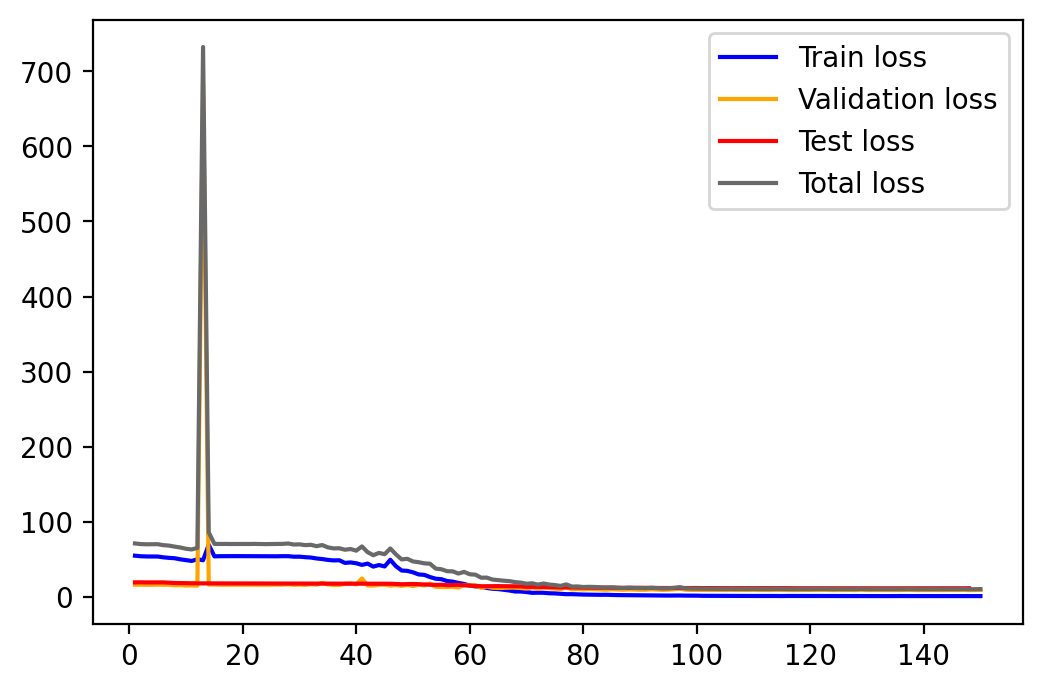

In [10]:
print("Train Loss: {:.4f} | Valid Loss: {:.4f} | Test Loss on Best Model: {:.4f}".format(besttrloss, bestvalloss, besttsloss))
plt.plot(ep,trainloss,color='blue', label = 'Train loss')
plt.plot(ep, validloss, color = 'orange',label = 'Validation loss')
plt.plot(testep, testloss, color = 'red',label = 'Test loss')
plt.plot(ep, totloss, color = 'dimgray',label = 'Total loss')
plt.legend()
plt.show()

In [11]:
tsloss = 0
with torch.no_grad():
    for batch_idx, (data, targets, _) in enumerate(test_loader):
        data = Variable(data).to(device)
        targets = Variable(targets.view(targets.shape[0],-1)).to(device)

        
        scores = best_model(data)
        loss = criterion(scores, targets)

        if batch_idx == 0:
            true_scores = targets.cpu().numpy()
            pred_scores = scores.cpu().numpy()
        else:
            true_scores = np.append(true_scores, targets.cpu().numpy(), axis = 0)
            pred_scores = np.append(pred_scores, scores.cpu().numpy(), axis = 0)


        tsloss += loss.item()


/home/vip/.local/lib/python3.8/site-packages/torch/nn/modules/rnn.py:661: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:915.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


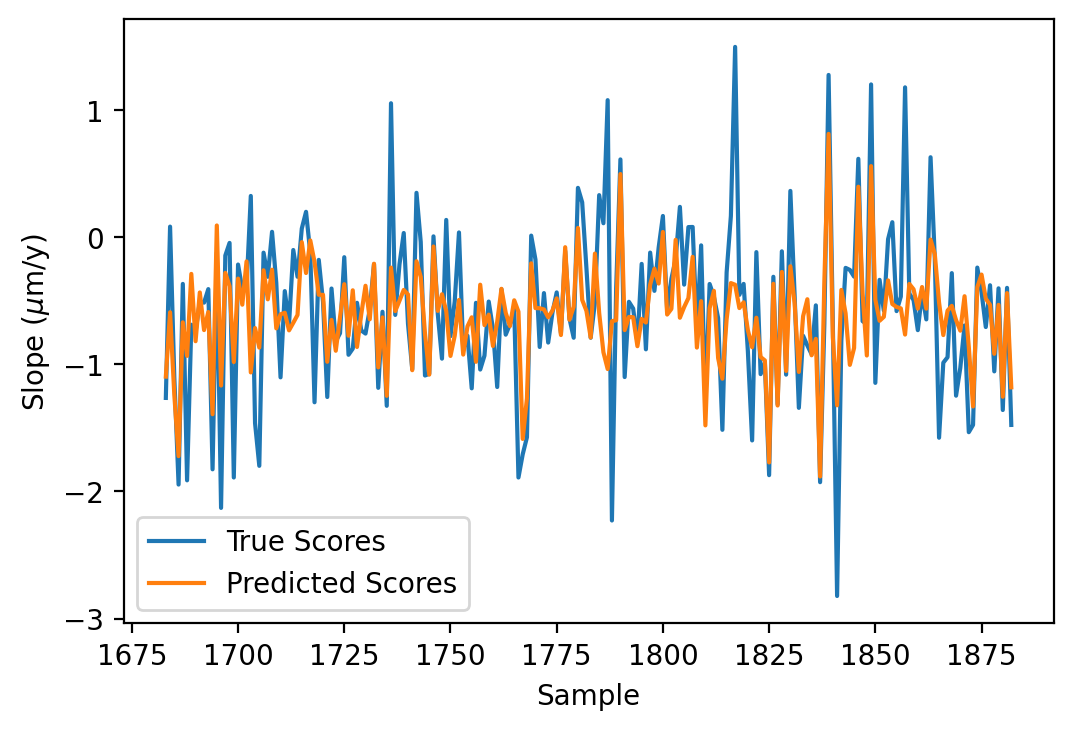

In [12]:
idx = np.array([i+1 for i in range(len(true_scores))])
size = 200
r = np.random.randint(len(idx)-size)
plt.plot(idx[r:r+size], true_scores[r:r+size], label = "True Scores")
plt.plot(idx[r:r+size], pred_scores[r:r+size],label = "Predicted Scores")
plt.ylabel('Slope ($\mu$m/y)')
plt.xlabel('Sample')
plt.legend()
plt.show()

<AxesSubplot:xlabel='Slope ($\\mu$m/y)', ylabel='Count'>

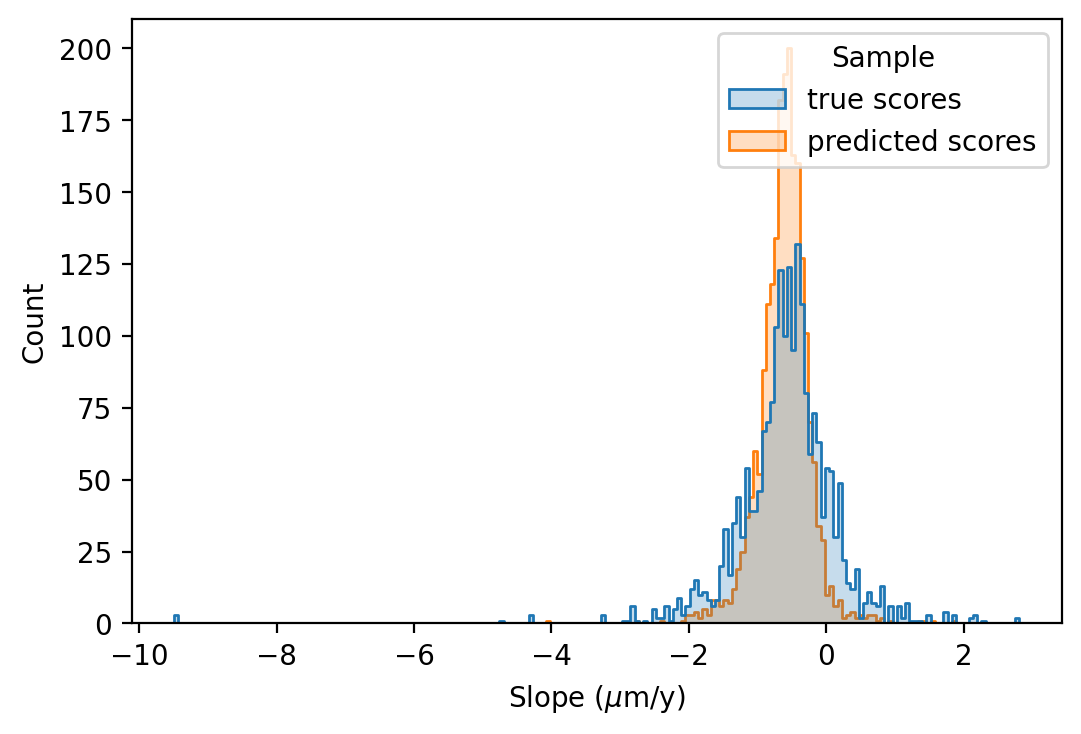

In [13]:
from scipy.stats import ks_2samp
dfx = pd.DataFrame.from_dict({'Slope ($\mu$m/y)': true_scores.ravel().tolist(), 'Sample':'true scores'})
dfy = pd.DataFrame.from_dict({'Slope ($\mu$m/y)': pred_scores.ravel().tolist(), 'Sample':'predicted scores'})
df = pd.concat(axis=0, ignore_index=True, objs=[dfx,dfy])



fig,ax = plt.subplots()
sns.histplot(df,x='Slope ($\mu$m/y)',hue='Sample',ax=ax, element='step')


In [14]:
print(ks_2samp(true_scores.ravel().tolist(),pred_scores.ravel().tolist()))

KstestResult(statistic=0.1583372255955161, pvalue=7.885294805905069e-24)


In [15]:
df.to_csv('predscores.csv')

In [16]:
ndf = pd.DataFrame({'ep': ep,
'train': trainloss,
'valid': validloss,'total':totloss})
ndf.to_csv('losses.csv')

ndf = pd.DataFrame({'ep': testep, 'test':testloss})
ndf.to_csv('testl.csv')

In [ ]:
if ks_2samp(true_scores.ravel().tolist(),pred_scores.ravel().tolist())[1]<0.05:
    plt.xlabel('Two scores are not from the same distribution')
else:
    plt.xlabel('Two scores are from the same distribution')

In [5]:
import pandas as pd
import numpy as np

In [6]:
df = pd.read_csv('predscores.csv')

In [7]:
true = np.array(df[df['Sample'] == 'true scores']['Slope ($\mu$m/y)'].tolist())

In [8]:
pred = np.array(df[df['Sample'] == 'predicted scores']['Slope ($\mu$m/y)'].tolist())

In [9]:
from sklearn.metrics import r2_score

coefficient_of_dermination = r2_score(true, pred)

In [10]:
coefficient_of_dermination

0.3957455743779068

In [11]:
import scipy
def rsquared(x, y):

    """ Return R^2 where x and y are array-like."""

    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    return r_value**2

In [12]:
rsquared(true, pred)

0.418285628483526

In [14]:
scipy.stats.spearmanr(true, pred)

SpearmanrResult(correlation=0.6499927059841695, pvalue=2.5767763167787183e-257)

In [15]:
scipy.stats.pearsonr(true, pred)

(0.6467500510116143, 6.0658240053933386e-254)